In [73]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This notebook is basically exercise 4's notebook applied to the final project

You can download the trajectory here:

https://www.dropbox.com/scl/fi/fd6xekl6ed4lqbp6vy7uv/Atg23_Atg9_350K_ff99_disp.nc?rlkey=zmsjqx7p1uykn2tahm20rzodr&st=8wv8tfnm&dl=0

This is a 60 nanosecond trajectory of Atg23-Atg9 complex at 350K with a99SB_disp force field. As the residues 1-40 and 40-70, forming Atg23's helices are not directly involved in binding Atg9, they were restrained to their AF2-predicted positions, along with the other parts of Atg23 that are not involved in binding, as otherwise Atg23 just melts itself forming a lot of sheets. Amber's manual was used to set up everything, along with the following tutorial for initial minimization:

https://ambermd.org/tutorials/basic/tutorial13/index.php

Atg23's small domain encompasses residues numbered 1-163, Atg9's binding peptide encompasses residues numbered 164-174 in the simulation (corresponds to the amino acids 14-24 of Atg9)

It can be compared to an AlphaFold2-Multimer predicted structure

In [74]:
#Load all files, need a separate prmtop file here because the trajectory is in a NetCDF format

prmtop='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23_Atg9.prmtop'
trajectory='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23_Atg9_350K_ff99_disp.nc'
AF2_pdb='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23W_Atg9N.pdb'
AF2_pdb_CA='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23W_Atg9N_CA.pdb'
outdir='/Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("prmtop:",prmtop)
print("trajectory:",trajectory)
print("AF2_pdb:",AF2_pdb)
print("AF2_pdb_CA:",AF2_pdb_CA)



outdir: /Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/output
prmtop: /Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23_Atg9.prmtop
trajectory: /Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23_Atg9_350K_ff99_disp.nc
AF2_pdb: /Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23W_Atg9N.pdb
AF2_pdb_CA: /Users/zhanibekbekkhozhin/Desktop/CHEM1016/Final_Project/Atg23W_Atg9N_CA.pdb


In [75]:
#Modified to load NetCDF files from Amber22
stride_sel=1
trj = md.load_netcdf(trajectory, top=prmtop,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=60
time=np.linspace(0,60,n_frames)

In [76]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 2796

Number of residues: 174

Number of frames: 3000

Starting frame: 0

Last frame: 3000

sequence:  [MET0, GLU1, LEU2, ASN3, GLN4, VAL5, LEU6, GLU7, LYS8, LYS9, GLU10, GLN11, ILE12, LEU13, GLN14, TYR15, LEU16, GLY17, THR18, LEU19, VAL20, GLY21, LEU22, HIS23, GLU24, LYS25, ALA26, LEU27, SER28, ASP29, VAL30, ASN31, SER32, ALA33, SER34, GLN35, VAL36, THR37, SER38, ILE39, ARG40, LYS41, ASP42, ILE43, THR44, ILE45, CYS46, LEU47, ASN48, ASP49, LEU50, CYS51, ARG52, ILE53, ASN54, ASP55, LEU56, LEU57, VAL58, SER59, HIS60, ASP61, GLY62, LEU63, LEU64, LYS65, ARG66, GLU67, GLY68, GLY69, GLN70, GLU71, GLN72, LEU73, MET74, ARG75, ASN76, LYS77, ASN78, GLU79, SER80, SER81, THR82, VAL83, LEU84, THR85, GLN86, ARG87, GLU88, LEU89, TRP90, LEU91, ASP92, CYS93, GLN94, LYS95, LYS96, VAL97, GLY98, ASP99, LEU100, GLU101, SER102, LYS103, LEU104, ILE105, THR106, LYS107, LEU108, ARG109, SER110, SER111, SER112, ASN113, SER114, LYS115, ILE116, PRO117, PRO118, ASN119, GLU120, ME

In [77]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [78]:
#I also created a CA only AF2 model
AF2_CA = md.load_pdb(AF2_pdb_CA)
top_AF2_CA = AF2_CA.topology
top_AF2_CA
residue_AF2_CA=[]
for res in top_AF2_CA.residues: 
    residue_AF2_CA.append(res.resSeq)
resid_AF2_CA=np.asarray(residue_AF2_CA)
resid_AF2_CA

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174])

In [79]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=prmtop,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


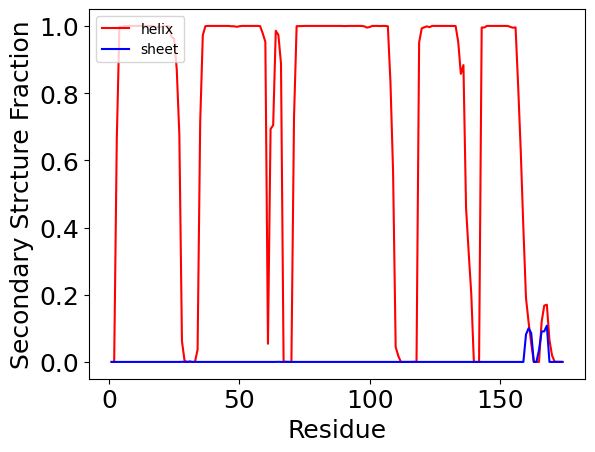

In [80]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_AF2_CA,Hprop,c='r',label='helix')
plt.plot(resid_AF2_CA,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

#As can be seen, there is some helicity for the Atg9 fragment in the end, although it stays helical not a lot and there is considerable
#beta sheet content for the Atg9 peptide, as well as Atg23's tail, and as will be shown later, these two beta sheet regions actually contact each other

In [81]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [82]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [83]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

In [84]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi_frames(res,frames):
 plt.hist2d(dihedral_dict['phi'][res][frames],dihedral_dict['psi'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi_frames(res,frames):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res][frames],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res][frames],dihedral_dict['chi2'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return


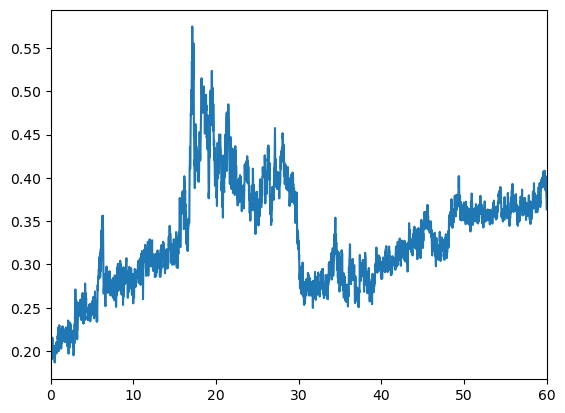

(array([  5.,  19.,  29.,  49.,  39.,  14.,  32.,  42.,  54.,  65., 127.,
        147., 165., 151., 174., 154., 150., 119.,  70.,  57.,  72., 179.,
        213., 167., 122.,  94.,  88.,  78.,  57.,  54.,  37.,  32.,  22.,
         21.,  11.,  15.,  13.,  18.,   7.,  10.,  13.,   4.,   4.,   1.,
          4.,   0.,   0.,   1.,   0.,   1.]),
 array([0.18687786, 0.1946353 , 0.20239273, 0.21015017, 0.21790759,
        0.22566503, 0.23342246, 0.2411799 , 0.24893732, 0.25669476,
        0.26445219, 0.27220961, 0.27996707, 0.28772449, 0.29548192,
        0.30323938, 0.3109968 , 0.31875423, 0.32651165, 0.33426911,
        0.34202653, 0.34978396, 0.35754138, 0.36529884, 0.37305626,
        0.38081369, 0.38857114, 0.39632857, 0.40408599, 0.41184342,
        0.41960087, 0.4273583 , 0.43511572, 0.44287315, 0.45063061,
        0.45838803, 0.46614546, 0.47390288, 0.48166034, 0.48941776,
        0.49717519, 0.50493264, 0.51269007, 0.52044749, 0.52820492,
        0.53596234, 0.54371977, 0.55147725, 0.

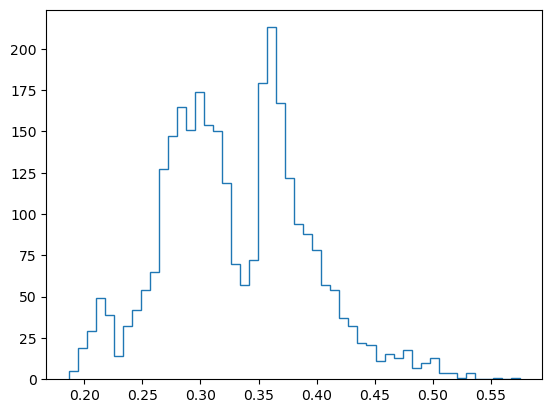

In [85]:
#Here, CA rmsd is compared to the AF2 structure. As can be seen, the RMSD first increases with a transition, then rapidly decreases,
#then gradually increases, reaching a local minimum. It seems it gets trapped in this state with beta sheets, so the whole project is kind of a failure

trjCA = md.load(trajectory, top=prmtop,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,AF2_CA)
plt.plot(time,rmsd)
plt.xlim(0,60)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)

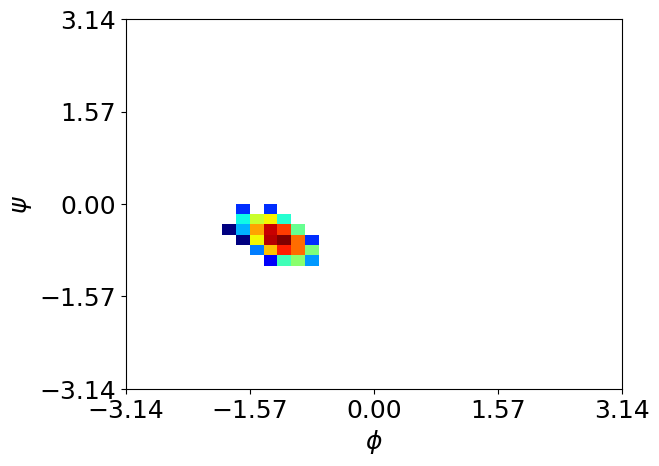

In [86]:
plot_phipsi(45)


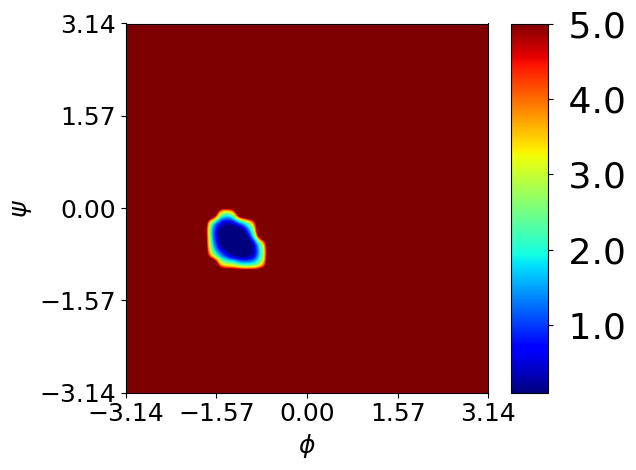

In [87]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(47)

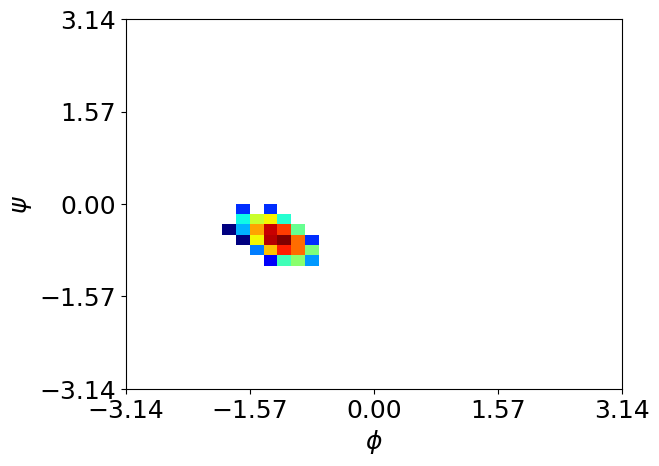

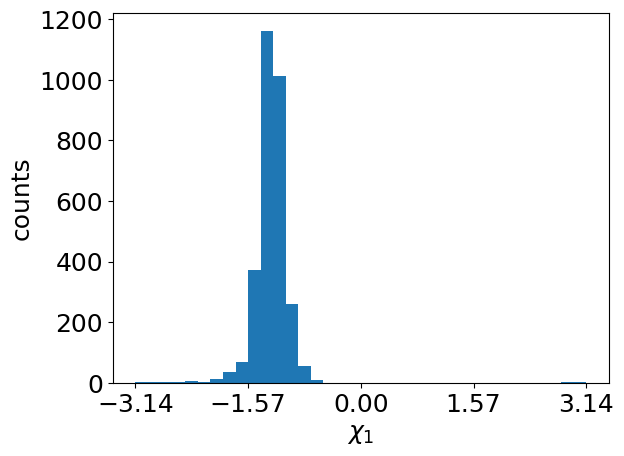

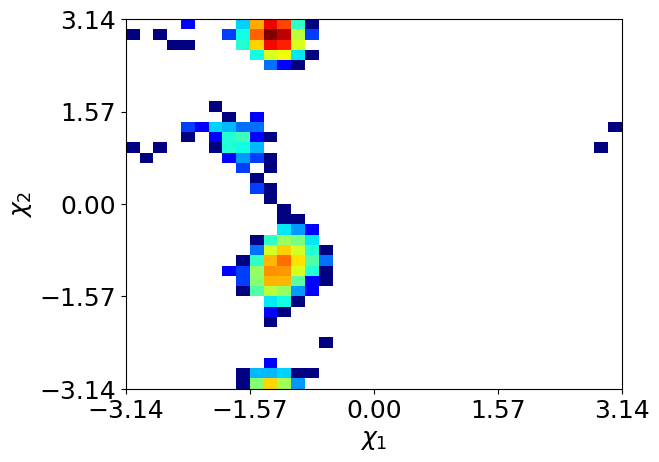

In [88]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [89]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


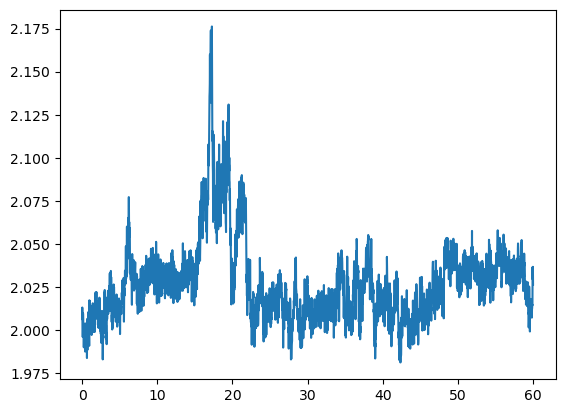

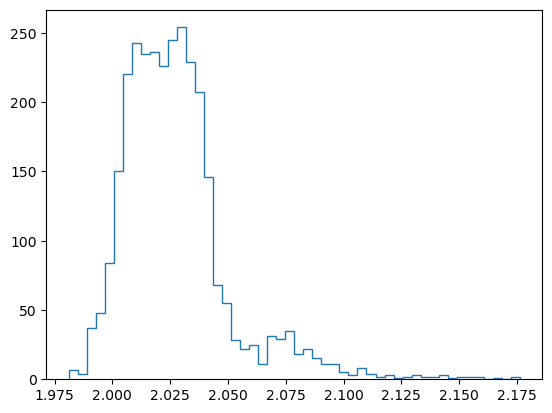

In [90]:
#Lets calculate the radius of gyration of Atg23-Atg9 complex. In accordance with the RMSD value, we capture the segment where Atg9 unbinds 
#and wonders around and then binds back. Rg captures this transition from bound to unbound in a more coarse-grained way, it does not 
#disvern between different bound conformations

rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [91]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(3000, 2)


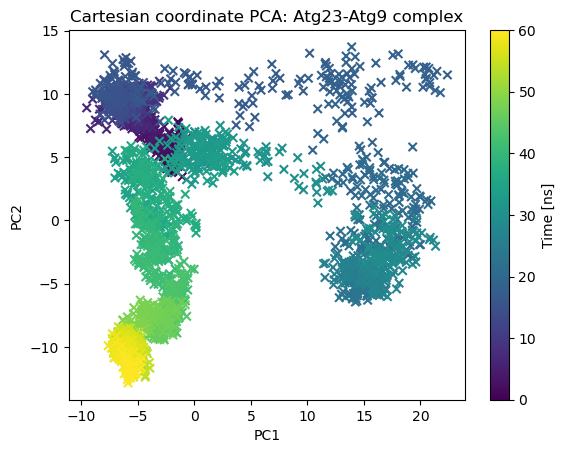

In [92]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Atg23-Atg9 complex')
cbar = plt.colorbar()
cbar.set_label('Time [ns]')

#Wow! We actually do capture the conformational wandering of the Atg23-Atg9 complex, seems like PC1 is sort of the distance between Atg23 and Atg9,
#it becomes much higher in the middle that corresponds to the unbound frames, but then PC2 can discern between more compact helical starting AF2 structure
#and the more elongated, beta-rich unnatural conformation present in the end of the simulation. So you can see the path it took

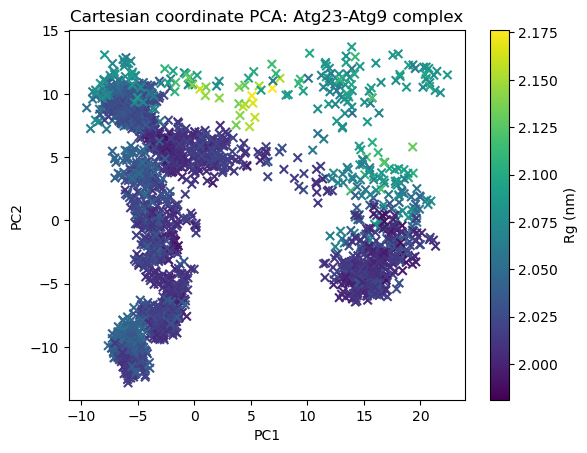

In [93]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Atg23-Atg9 complex')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

#This seems to be less informative, which is to be expected, when Rg is computed, it is computed on the whole Atg23-Atg9 complex, so significant
#changes in the Atg9 binding peptide will be masked away by the Atg23 that is way bigger and makes all Rgs appear similar

#I know I should have computed Rg of the Atg9 only but honestly I just want to just pass the course, the used MD model seems to be not very useful anyway

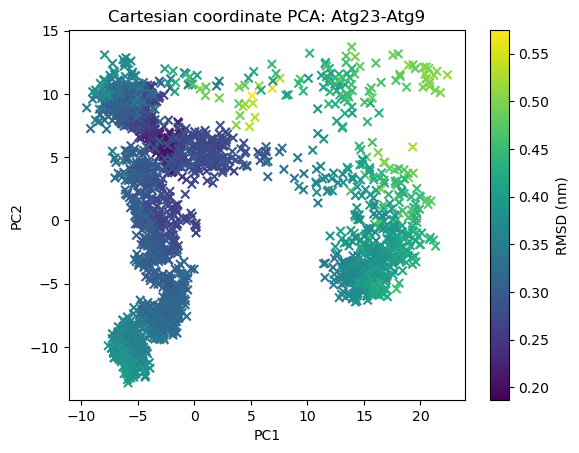

In [94]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Atg23-Atg9')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

#Same as with time series, one can see that the higher RMSD gets clustered towards higher PC1 values

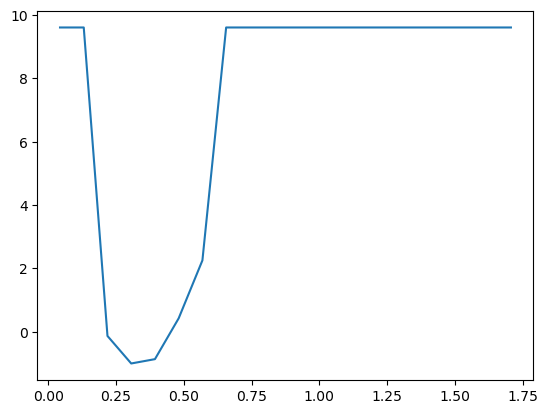

In [96]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

*** Lets plot the free energy as a function of Rg vs. RMSD***

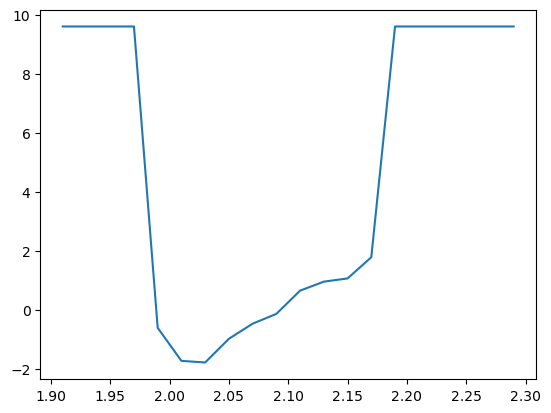

In [97]:
dG_rg,xedges=free_energy1D(rg,300,1.9,2.3,20)

plt.plot(xedges,dG_rg)

In [106]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(100, 174):
    contact_map = []
    contact_distance = []
    for j in range(100, 174):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [107]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=5
for i in range (100,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

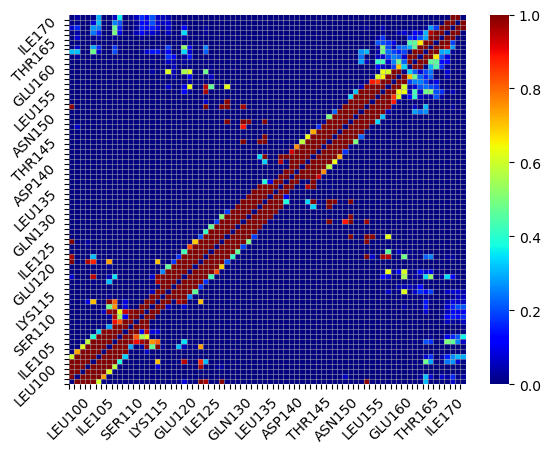

In [108]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,74))
ax.set_yticks(range(0,74))
ax.set_xticklabels(sequence[100:174],rotation=45)
ax.set_yticklabels(sequence[100:174],rotation=45)
plt.show()

#The C-terminal part of Atg23 and the Atg 9 peptide are captured here. As can be seen, interhelical contacts between Atg23's helices are very strong
#and are present throughout the entire trajectory, whereas Atg9, which starts with lysine 164, makes most important contact with threonine 166 and phenylalanine 167,
#which is highlighted as the two green squares off the diagonal. They make contact with the aa 106-107 of Atg23, which is also seen in the simulation

In [111]:
#After minimization, the structure looks almost identical to the AF2 structure, just the tail of Atg9 flipped out slightly
#Cyan is the AF2 structure, orange is the backbone Atg23, red are the md atoms, with the most important THR166, PHE167 and LEU168 shown in green
from IPython.display import Image
Image(url = "Initial.jpeg",width = 720, height = 480)

In [112]:
#After some time, the tail of Atg9 unbinds a bit further
Image(url = "Bound.jpeg",width = 720, height = 480)

In [113]:
#Atg9 then transiently translocates upwards, with the phenylalanine still making a loose contact with Atg23
Image(url = "Loosely_Bound.jpeg",width = 720, height = 480)

In [115]:
#Finally, Atg9 is ejected into the outer space at 350K
#You can also see that the lower "jaw" in orange is now closed in Atg23
Image(url = "Unbinding_Transition.jpeg",width = 720, height = 480)

In [116]:
#It wonders around a bit
Image(url = "Unbound_Far.jpeg",width = 720, height = 480)

In [117]:
#Until it binds back on the outer surface of Atg23
Image(url = "Unbound_Close.jpeg",width = 720, height = 480)

In [118]:
#Sampling different binding poses
Image(url = "Unbound_Close_2.jpeg",width = 720, height = 480)

In [119]:
#Finally, it binds back to its native pocket with one large difference: the lower "jaw" part is now closed and thus binding in the same pose
#is no longer possible. So instead it binds into a more narrow canyon on the surface of Atg23
Image(url = "Rebound.jpeg",width = 720, height = 480)

In [121]:
#After some time, the C-terminal helix on Atg23 unwinds (shown as an orange beta sheet)
Image(url = "Rebound_Cterm_unwinding.jpeg",width = 720, height = 480)

In [122]:
#And the Atg9's peptide makes a complementary beta sheet
Image(url = "Rebound_beta.jpeg",width = 720, height = 480)

In [ ]:
#Overall, I tried simulating different temperatures but they all give this unrealistic beta sheet; using other force fields just makes the complex
#too tight and there are no binding-unbinding transitions.

#The biggest hurdle, in my opinion, is that after Atg23's jaw has been closed, there is no binding pocket anymore, so real rebinding can not occur
#I could not solve this problem and just gave up. I hope that this, together with installing the RoseTTAFold is enough for a pass, not high pass